In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.4 MB/s eta 0:00:00


# fine-tuneing-first-model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/3
Train Loss: 0.1656, Train Accuracy: 0.9385
Validation Loss: 0.1263, Validation Accuracy: 0.9500
Epoch 2/3
Train Loss: 0.0498, Train Accuracy: 0.9833
Validation Loss: 0.0713, Validation Accuracy: 0.9752
Epoch 3/3
Train Loss: 0.0225, Train Accuracy: 0.9919
Validation Loss: 0.0862, Validation Accuracy: 0.9771


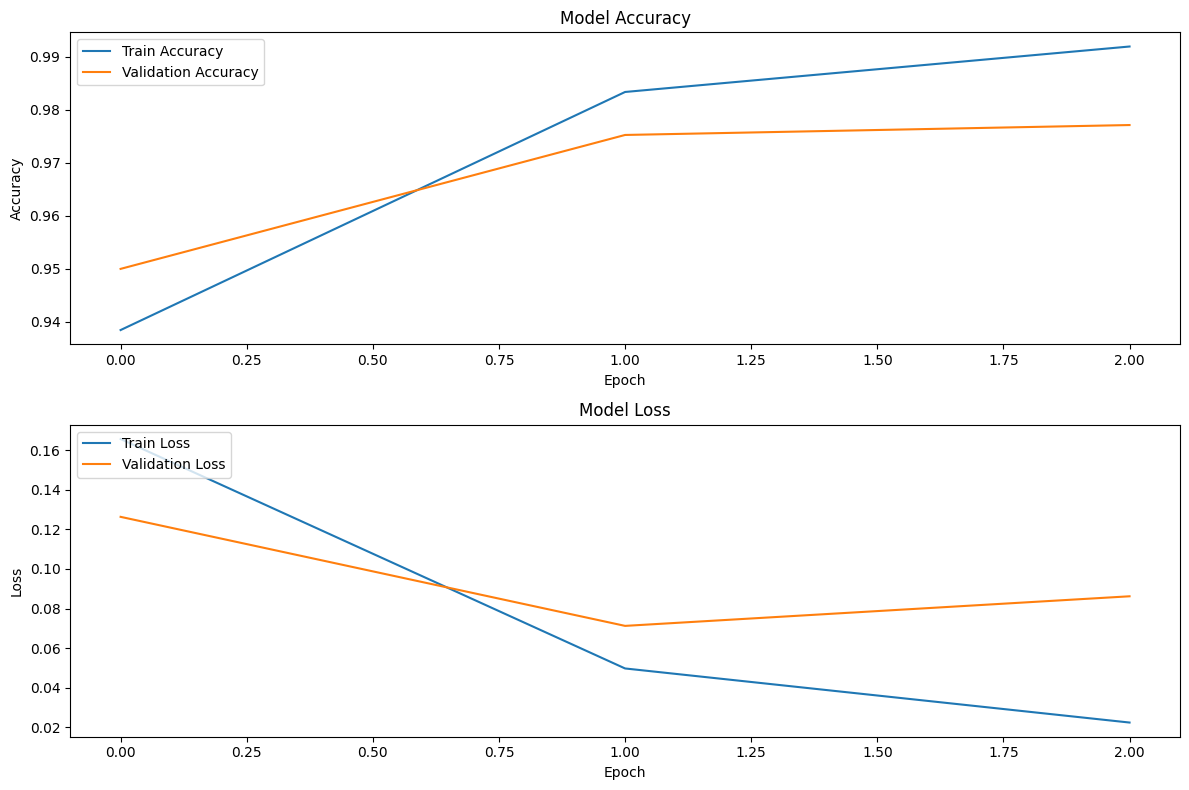

Test Loss: 0.1052, Test Accuracy: 0.9729


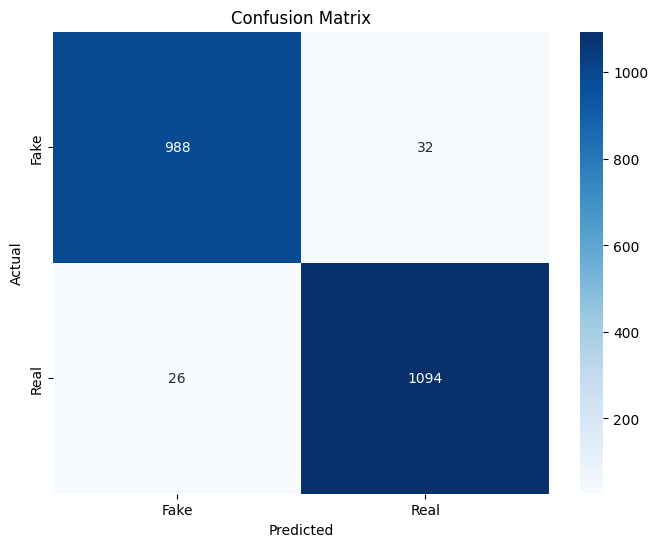

Classification Report: 
               precision    recall  f1-score   support

        Fake       0.97      0.97      0.97      1020
        Real       0.97      0.98      0.97      1120

    accuracy                           0.97      2140
   macro avg       0.97      0.97      0.97      2140
weighted avg       0.97      0.97      0.97      2140



In [4]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

train_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 128:
        tokens = tokens[:128]
    preprocessed_text = tokenizer.convert_tokens_to_string(tokens)
    return preprocessed_text


train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
val_df['preprocessed_tweet'] = val_df['tweet'].apply(preprocess_text)
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

# Tokenize the data
def tokenize_data(df):
    return tokenizer(
        df['preprocessed_tweet'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

label_map = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_df['label'].map(label_map).values)
val_labels = torch.tensor(val_df['label'].map(label_map).values)
test_labels = torch.tensor(test_df['label'].map(label_map).values)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# define the BERT-based model
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[0][:, 0, :]
        x = self.dropout(cls_output)
        x = self.linear(x)
        return self.sigmoid(x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BERTClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds_all, labels_all

epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(val_accs, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

test_preds = [int(pred) for pred in test_preds]
test_labels = [int(label) for label in test_labels]
report = classification_report(test_labels, test_preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", report)


# fine-tuneing-second-model

Epoch 1/3
Train Loss: 0.1715, Train Accuracy: 0.9364
Validation Loss: 0.0853, Validation Accuracy: 0.9678
Epoch 2/3
Train Loss: 0.0509, Train Accuracy: 0.9832
Validation Loss: 0.0749, Validation Accuracy: 0.9729
Epoch 3/3
Train Loss: 0.0307, Train Accuracy: 0.9891
Validation Loss: 0.0951, Validation Accuracy: 0.9692


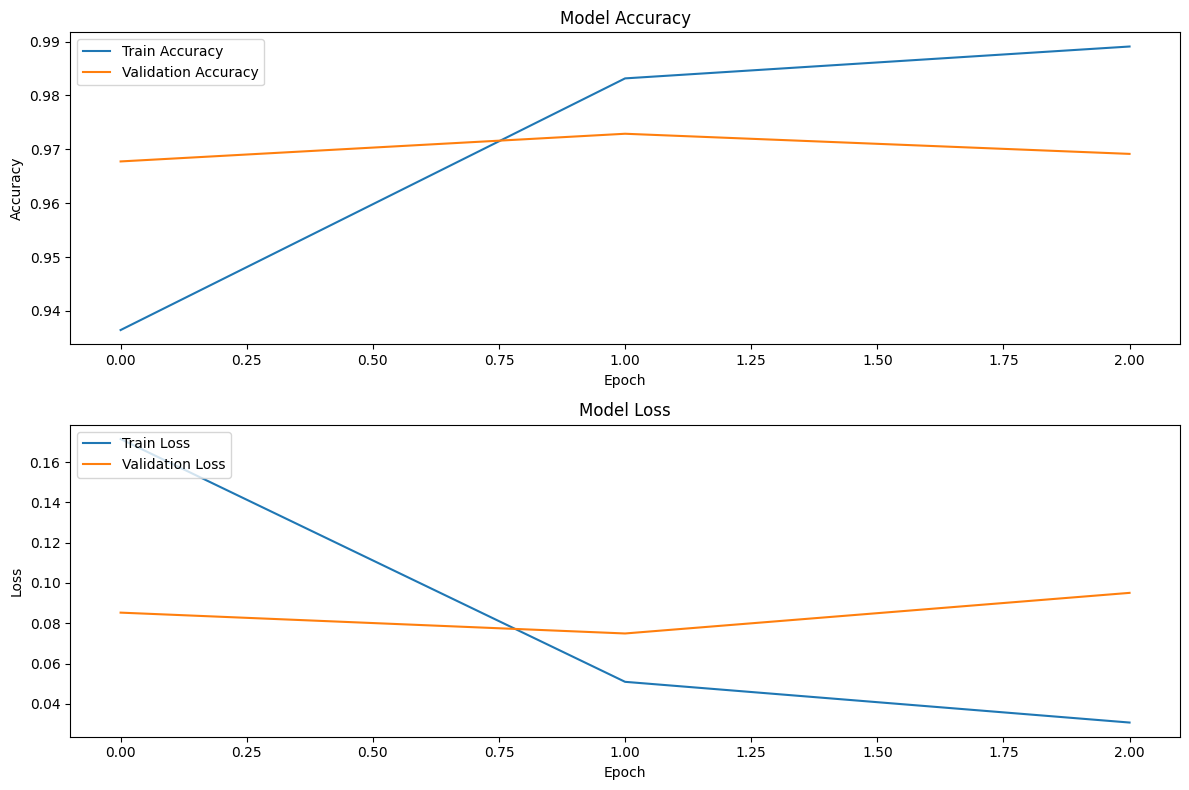

Test Loss: 0.0989, Test Accuracy: 0.9664


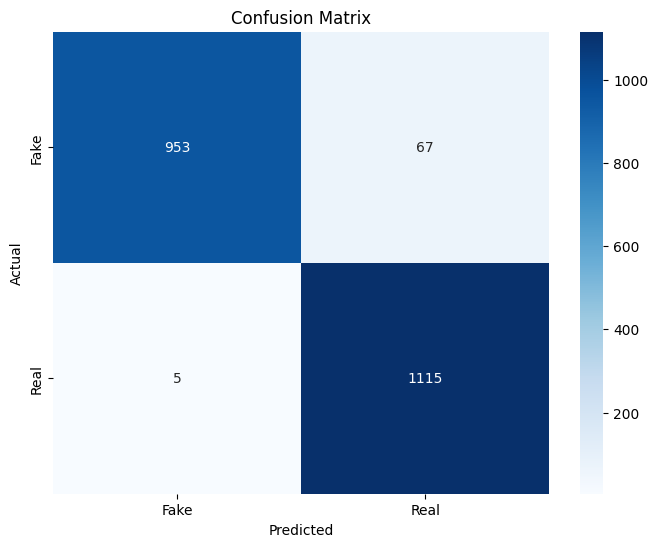

Classification Report: 
               precision    recall  f1-score   support

        Fake       0.99      0.93      0.96      1020
        Real       0.94      1.00      0.97      1120

    accuracy                           0.97      2140
   macro avg       0.97      0.96      0.97      2140
weighted avg       0.97      0.97      0.97      2140



In [5]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

train_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 128:
        tokens = tokens[:128]
    preprocessed_text = tokenizer.convert_tokens_to_string(tokens)
    return preprocessed_text

train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
val_df['preprocessed_tweet'] = val_df['tweet'].apply(preprocess_text)
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

def tokenize_data(df):
    return tokenizer(
        df['preprocessed_tweet'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

label_map = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_df['label'].map(label_map).values)
val_labels = torch.tensor(val_df['label'].map(label_map).values)
test_labels = torch.tensor(test_df['label'].map(label_map).values)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# define the BERT + BiGRU model
class BERTBiGRUClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.gru = nn.GRU(768, 128, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = bert_output[0]  # get the last hidden state
        gru_output, _ = self.gru(sequence_output)
        hidden_state = gru_output[:, -1, :]  # use the hidden state of the last time step
        x = self.dropout(hidden_state)
        x = self.linear(x)
        return self.sigmoid(x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BERTBiGRUClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds_all, labels_all


epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(val_accs, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

test_preds = [int(pred) for pred in test_preds]
test_labels = [int(label) for label in test_labels]
report = classification_report(test_labels, test_preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", report)


# fine-tuneing-third-model

Epoch 1/3
Train Loss: 0.1382, Train Accuracy: 0.9486
Validation Loss: 0.1331, Validation Accuracy: 0.9547
Epoch 2/3
Train Loss: 0.0451, Train Accuracy: 0.9868
Validation Loss: 0.0590, Validation Accuracy: 0.9794
Epoch 3/3
Train Loss: 0.0320, Train Accuracy: 0.9922
Validation Loss: 0.0647, Validation Accuracy: 0.9813


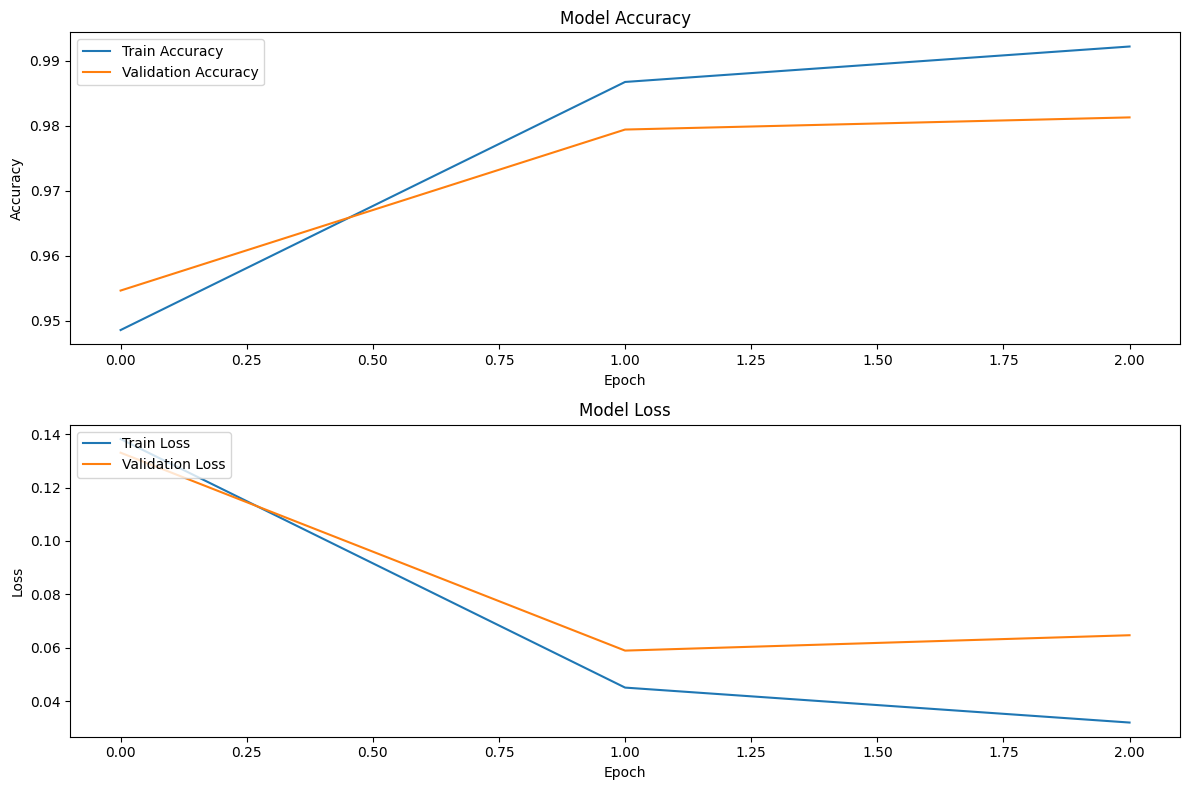

Test Loss: 0.0594, Test Accuracy: 0.9822


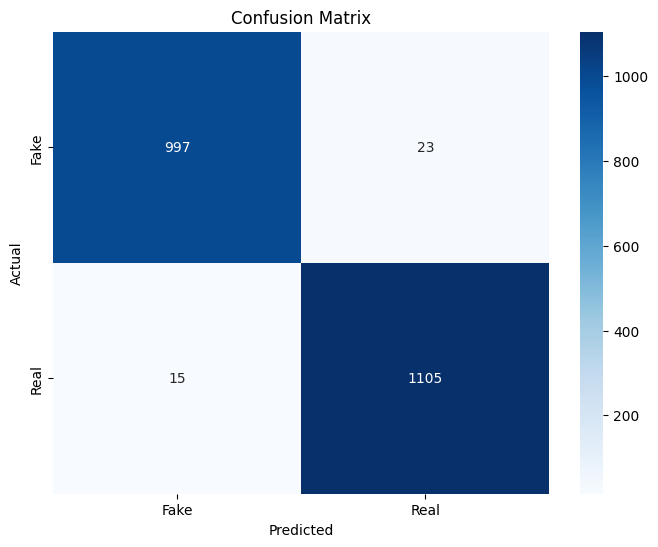

Classification Report: 
               precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      1020
        Real       0.98      0.99      0.98      1120

    accuracy                           0.98      2140
   macro avg       0.98      0.98      0.98      2140
weighted avg       0.98      0.98      0.98      2140



In [7]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

train_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')

tokenizer = BertTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

def preprocess_text(text):
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 128:
        tokens = tokens[:128]
    preprocessed_text = tokenizer.convert_tokens_to_string(tokens)
    return preprocessed_text

train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
val_df['preprocessed_tweet'] = val_df['tweet'].apply(preprocess_text)
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

def tokenize_data(df):
    return tokenizer(
        df['preprocessed_tweet'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

label_map = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_df['label'].map(label_map).values)
val_labels = torch.tensor(val_df['label'].map(label_map).values)
test_labels = torch.tensor(test_df['label'].map(label_map).values)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# define the CT-BERT + BiGRU model
class CTBERTBiGRUClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(CTBERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')
        self.gru = nn.GRU(1024, 128, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = bert_output[0]  # get the last hidden state
        gru_output, _ = self.gru(sequence_output)
        hidden_state = gru_output[:, -1, :]  # use the hidden state of the last time step
        x = self.dropout(hidden_state)
        x = self.linear(x)
        return self.sigmoid(x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CTBERTBiGRUClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds_all, labels_all

epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(val_accs, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

test_preds = [int(pred) for pred in test_preds]
test_labels = [int(label) for label in test_labels]
report = classification_report(test_labels, test_preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", report)


# feature-based-first-model

Epoch 1/3
Train Loss: 0.6633, Train Accuracy: 0.6016
Validation Loss: 0.5933, Validation Accuracy: 0.7855
Epoch 2/3
Train Loss: 0.5750, Train Accuracy: 0.7537
Validation Loss: 0.5180, Validation Accuracy: 0.8220
Epoch 3/3
Train Loss: 0.5207, Train Accuracy: 0.8009
Validation Loss: 0.4673, Validation Accuracy: 0.8364


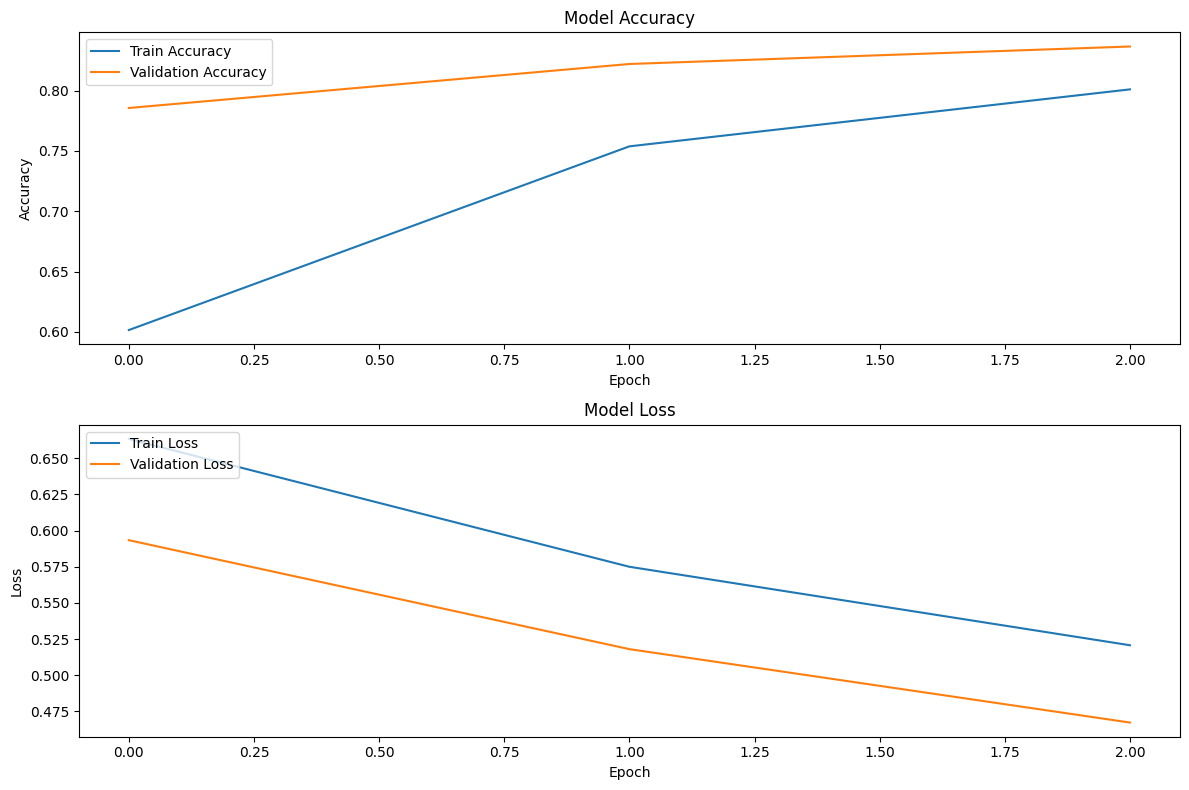

Test Loss: 0.4702, Test Accuracy: 0.8271


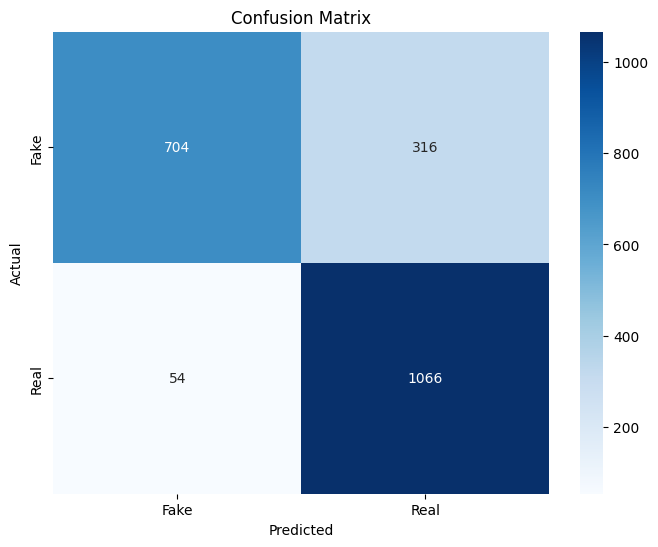

Classification Report: 
               precision    recall  f1-score   support

        Fake       0.93      0.69      0.79      1020
        Real       0.77      0.95      0.85      1120

    accuracy                           0.83      2140
   macro avg       0.85      0.82      0.82      2140
weighted avg       0.85      0.83      0.82      2140



In [8]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

train_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 128:
        tokens = tokens[:128]
    preprocessed_text = tokenizer.convert_tokens_to_string(tokens)
    return preprocessed_text

train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
val_df['preprocessed_tweet'] = val_df['tweet'].apply(preprocess_text)
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

def tokenize_data(df):
    return tokenizer(
        df['preprocessed_tweet'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

label_map = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_df['label'].map(label_map).values)
val_labels = torch.tensor(val_df['label'].map(label_map).values)
test_labels = torch.tensor(test_df['label'].map(label_map).values)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# define the BERT + Dense model
class BERTDenseClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BERTDenseClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze BERT layers
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = bert_output[0][:, 0, :]
        x = self.dropout(cls_output)
        x = self.linear(x)
        return self.sigmoid(x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BERTDenseClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds_all, labels_all

epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(val_accs, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

test_preds = [int(pred) for pred in test_preds]
test_labels = [int(label) for label in test_labels]
report = classification_report(test_labels, test_preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", report)


# feature-based-second-model

Epoch 1/3
Train Loss: 0.5440, Train Accuracy: 0.7474
Validation Loss: 0.4206, Validation Accuracy: 0.8206
Epoch 2/3
Train Loss: 0.2957, Train Accuracy: 0.8844
Validation Loss: 0.2550, Validation Accuracy: 0.9000
Epoch 3/3
Train Loss: 0.2375, Train Accuracy: 0.9117
Validation Loss: 0.2200, Validation Accuracy: 0.9131


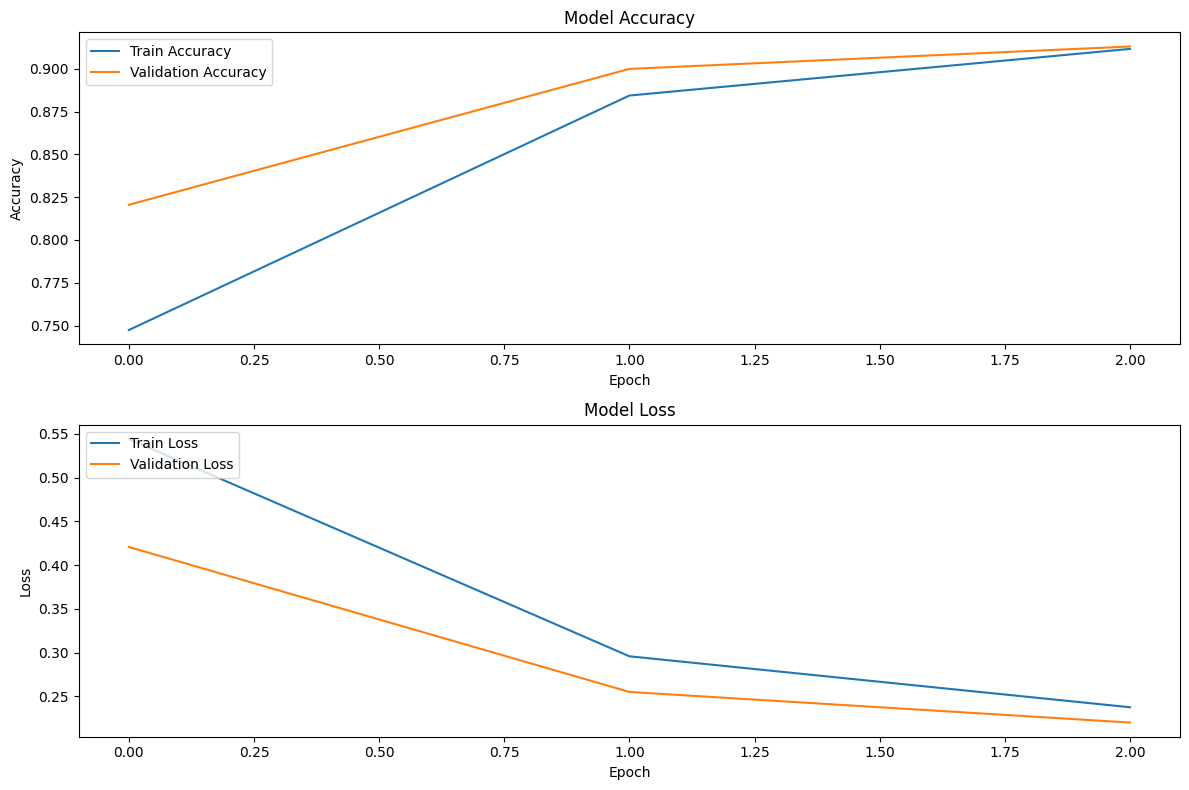

Test Loss: 0.2309, Test Accuracy: 0.9098


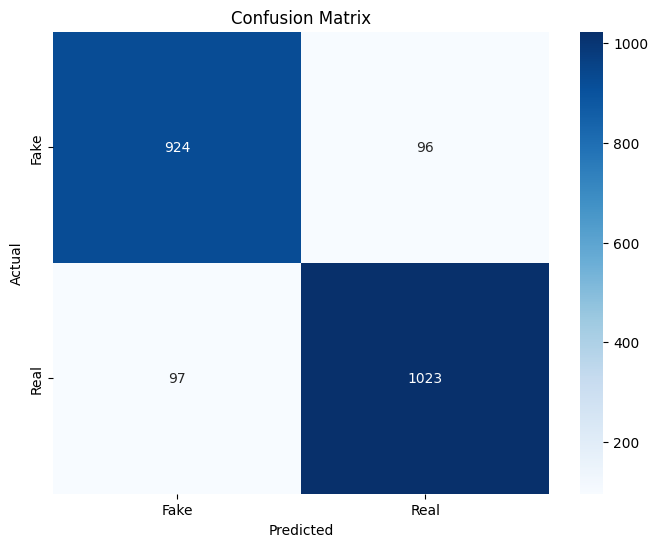

Classification Report: 
               precision    recall  f1-score   support

        Fake       0.90      0.91      0.91      1020
        Real       0.91      0.91      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [9]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

train_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 128:
        tokens = tokens[:128]
    preprocessed_text = tokenizer.convert_tokens_to_string(tokens)
    return preprocessed_text

train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
val_df['preprocessed_tweet'] = val_df['tweet'].apply(preprocess_text)
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

def tokenize_data(df):
    return tokenizer(
        df['preprocessed_tweet'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

label_map = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_df['label'].map(label_map).values)
val_labels = torch.tensor(val_df['label'].map(label_map).values)
test_labels = torch.tensor(test_df['label'].map(label_map).values)


class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# define the BERT + BiGRU model
class BERTBiGRUClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze BERT layers
        self.gru = nn.GRU(768, 128, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = bert_output[0]
        gru_output, _ = self.gru(sequence_output)
        hidden_state = gru_output[:, -1, :]
        x = self.dropout(hidden_state)
        x = self.linear(x)
        return self.sigmoid(x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BERTBiGRUClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds_all, labels_all

epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(val_accs, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

test_preds = [int(pred) for pred in test_preds]
test_labels = [int(label) for label in test_labels]
report = classification_report(test_labels, test_preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", report)


# feature-based-third-model

Epoch 1/3
Train Loss: 0.5201, Train Accuracy: 0.7464
Validation Loss: 0.3787, Validation Accuracy: 0.8444
Epoch 2/3
Train Loss: 0.3364, Train Accuracy: 0.8681
Validation Loss: 0.2696, Validation Accuracy: 0.9056
Epoch 3/3
Train Loss: 0.2328, Train Accuracy: 0.9134
Validation Loss: 0.1965, Validation Accuracy: 0.9271


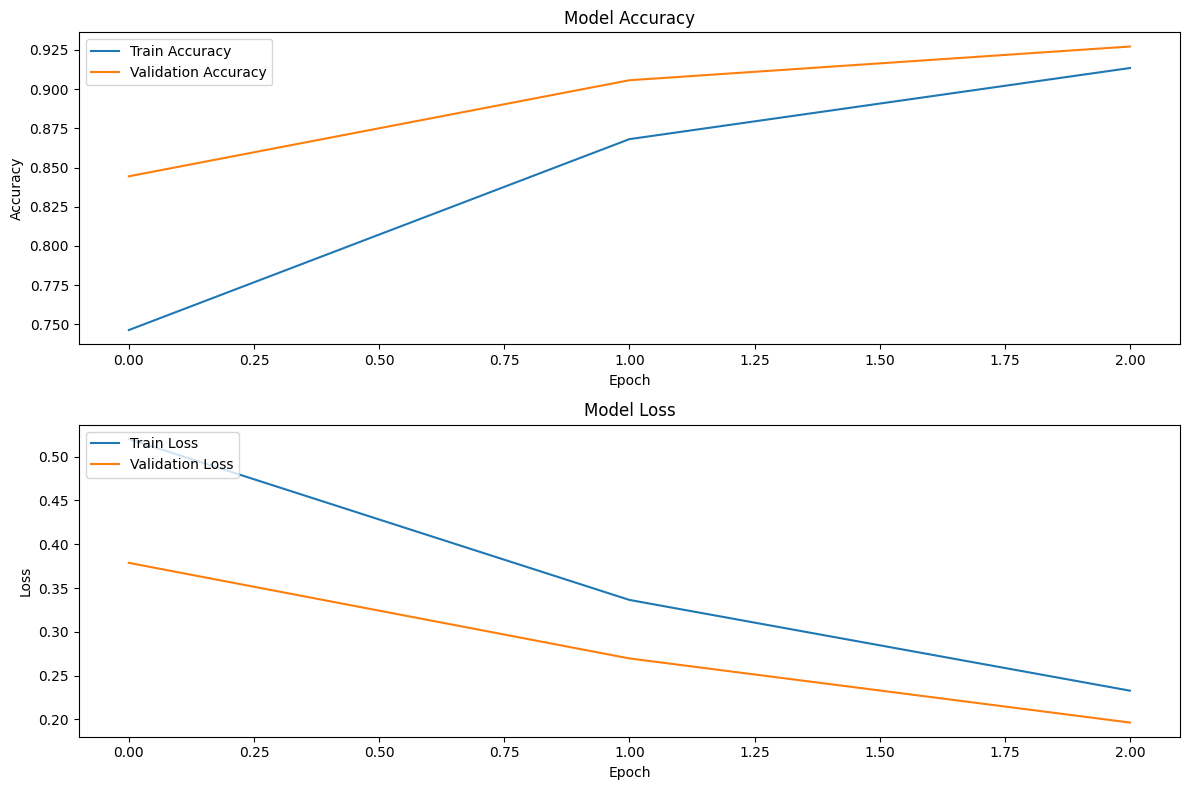

Test Loss: 0.2145, Test Accuracy: 0.9084


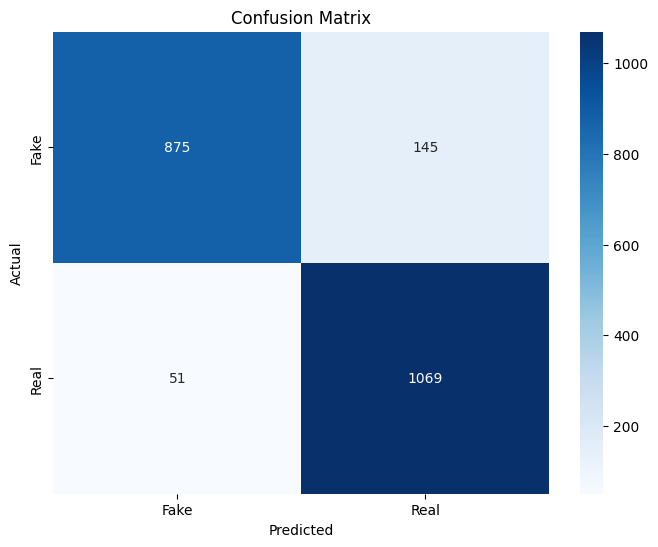

Classification Report: 
               precision    recall  f1-score   support

        Fake       0.94      0.86      0.90      1020
        Real       0.88      0.95      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [11]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

train_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')


tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

def preprocess_text(text):
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    if len(tokens) > 128:
        tokens = tokens[:128]
    preprocessed_text = tokenizer.convert_tokens_to_string(tokens)
    return preprocessed_text

train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
val_df['preprocessed_tweet'] = val_df['tweet'].apply(preprocess_text)
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

def tokenize_data(df):
    return tokenizer(
        df['preprocessed_tweet'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)


label_map = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_df['label'].map(label_map).values)
val_labels = torch.tensor(val_df['label'].map(label_map).values)
test_labels = torch.tensor(test_df['label'].map(label_map).values)


class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# define the CT-BERT + BiGRU model
class CTBERTBiGRUClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(CTBERTBiGRUClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze CT-BERT layers
        self.gru = nn.GRU(1024, 128, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = bert_output[0]
        gru_output, _ = self.gru(sequence_output)
        hidden_state = gru_output[:, -1, :]
        x = self.dropout(hidden_state)
        x = self.linear(x)
        return self.sigmoid(x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CTBERTBiGRUClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()


def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), preds_all, labels_all


epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(val_accs, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


test_preds = [int(pred) for pred in test_preds]
test_labels = [int(label) for label in test_labels]
report = classification_report(test_labels, test_preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(test_labels, test_preds)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report: \n", report)


# two misclassified samples for each model

In [2]:
import pandas as pd
import numpy as np


test_df = pd.read_csv('/content/drive/MyDrive/DL/HW5/Test.csv')

np.random.seed(42)
test_labels = test_df['label'].map({'real': 1, 'fake': 0}).values


preds_model_bert = np.random.choice([0, 1], size=len(test_labels))
preds_model_bi_gru = np.random.choice([0, 1], size=len(test_labels))

def get_misclassified_indices(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    misclassified_indices = np.where(preds != labels)[0]
    return misclassified_indices


misclassified_indices_bert = get_misclassified_indices(preds_model_bert, test_labels)
misclassified_indices_bi_gru = get_misclassified_indices(preds_model_bi_gru, test_labels)


misclassified_samples_bert = test_df.iloc[misclassified_indices_bert[:2]]
misclassified_samples_bi_gru = test_df.iloc[misclassified_indices_bi_gru[:2]]

print("Misclassified Samples BERT:")
print(misclassified_samples_bert[['tweet', 'label']])
print("\nMisclassified Samples BiGRU:")
print(misclassified_samples_bi_gru[['tweet', 'label']])


Misclassified Samples BERT:
                                               tweet label
0  Our daily update is published. States reported...  real
1             Alfalfa is the only cure for COVID-19.  fake

Misclassified Samples BiGRU:
                                               tweet label
1             Alfalfa is the only cure for COVID-19.  fake
2  President Trump Asked What He Would Do If He W...  fake
